
# Heatwave detection

According to the Intergovernmental Panel on Climate Change (IPCC), a heatwave can be defined as "a period of abnormally hot weather, often defined with reference to a relative temperature threshold, lasting from two days to months" [1]. Such a definition is rather vague and can be easily adapted to depending on the local context. For instance, MeteoSwiss distinguishes between four level of heat warnings [2] depending on both the period duration and temperature thresholds.

This notebook shows how meteora can be used to detect heatwave periods, providing the user with flexibility to adapt to local heatwave definitions. To that end, we will use the [the Global Historical Climatology Network hourly (GHCNh)](https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly) dataset. Let us start with some imports:

In [ ]:
import datetime as dt

import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd

from meteora import utils
from meteora.clients import GHCNHourlyClient

figwidth, figheight = plt.rcParams["figure.figsize"]

We will get the GHCNh data for the June-July-August (JJA) periods of 2022 to 2024 for an area surrounding the city of Zurich (Switzerland):

In [ ]:
region = [8.3424, 47.3416, 8.6734, 47.4673]
# select study period
start_year = 2022
end_year = 2024
# months to consider when querying the GHCNh data
start_month = 6
end_month = 8

We can first plot the station locations:

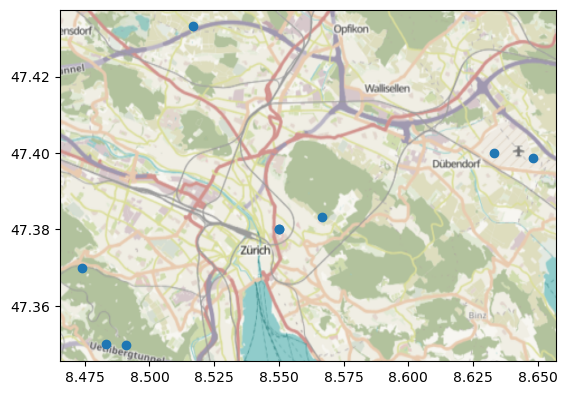

In [ ]:
client = GHCNHourlyClient(region)
ax = client.stations_gdf.plot()
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution="")

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

Then, we will get the JJA time series of temperature measurements:

In [ ]:
ts_df = pd.concat(
    [
        client.get_ts_df(
            "temperature",
            dt.date(year, start_month, 1),
            # get latest moment of the latest day of the month
            # ACHTUNG: this won't work if `end_month` is 12 (see commented code below)
            dt.datetime.combine(
                dt.date(year, end_month + 1, 1) - dt.timedelta(days=1), dt.time.max
            ),
            # dt.date(year + int(end_month / 12), (end_month % 12) + 1, 1)
            # - dt.timedelta(days=1),
        )
        for year in range(start_year, end_year + 1)
    ],
    axis="rows",
)
# convert to wide format
ts_df = utils.long_to_wide(ts_df)
ts_df

[########################################] | 100% Completed | 706.12 ms
[########################################] | 100% Completed | 813.11 ms
[########################################] | 100% Completed | 808.60 ms


station_id,SZI0000LSMD,SZM00006660,SZM00006664,SZM00006807
time,,,,
2022-06-01 00:00:00,NaN,13.8,11.6,NaN
2022-06-01 00:20:00,13.0,NaN,NaN,NaN
2022-06-01 00:50:00,13.0,NaN,NaN,NaN
2022-06-01 01:00:00,NaN,12.9,10.6,NaN
2022-06-01 01:20:00,13.0,NaN,NaN,NaN
...,...,...,...,...
2024-08-31 22:20:00,21.0,NaN,20.0,21.0
2024-08-31 22:50:00,20.0,NaN,20.0,20.0
2024-08-31 23:00:00,NaN,21.0,18.9,NaN


According to the MeteoSwiss heat warning system, a *level 4* warning is issued when the daily mean temperature is equal or greater than 27°C for at least 3 days. In order to detect a period with such characteristics, we can use the `meteora.utils.get_heatwave_periods` function, which takes a time series data frame as the only positional argument, followed by a series of keyword-only arguments. For this example, we need to set:
- `heatwave_t_threshold` as the temperature threshold (the default is 25)
- `heatwave_n_consecutive_days` as the number of consecutive days (the default is 3)
- `station_agg_func` as the function to aggregate each station's daily time series (the default is "mean"

In [ ]:
heatwave_periods = utils.get_heatwave_periods(
    ts_df,
    heatwave_t_threshold=27,
    heatwave_n_consecutive_days=3,
    station_agg_func="mean",
)
heatwave_periods

[]

As we can see, there is no heatwave fullfilling these characteristics for our study area during the specified period. Let us now try to find periods of *level 3* warnings, i.e., when the mean daily temperature is equal or greater than 25°C for at least 3 days:

In [ ]:
heatwave_periods = utils.get_heatwave_periods(
    ts_df,
    heatwave_t_threshold=25,
    heatwave_n_consecutive_days=3,
    station_agg_func="mean",
)
heatwave_periods

[(datetime.datetime(2023, 8, 19, 0, 0),
  datetime.datetime(2023, 8, 23, 23, 59, 59, 999999))]

We get a single heatwave that spans from the 19th to the 23rd of August 2023. We can also use this information to extract the time series of this period:

<Axes: xlabel='time'>

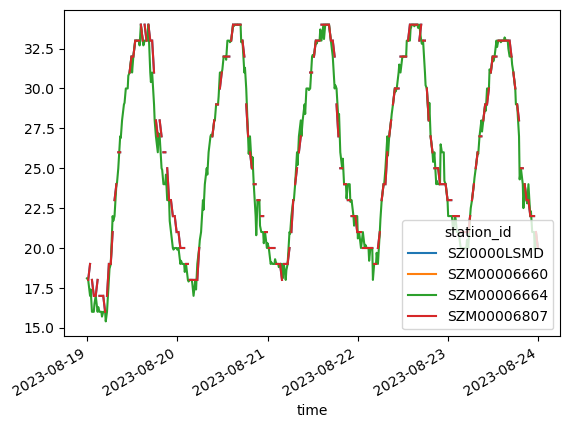

In [ ]:
heatwave_start, heatwave_end = heatwave_periods[0]
ts_df.loc[heatwave_start:heatwave_end].plot()

Since there are four stations in our study area, we have four daily means to compare with `heatwave_t_threshold`. By default, the `meteora.utils.get_heatwave_periods` function will compare the threshold with the mean among all stations of `ts_df`, however we can change this behaviour through the `inter_station_agg_func` keyword argument. For instance, we can set to `"max"` so that a day is considered as a potential part of a heatwave when (at least) one of the stations is over the temperature threshold:

In [ ]:
heatwave_periods = utils.get_heatwave_periods(
    ts_df,
    heatwave_t_threshold=25,
    heatwave_n_consecutive_days=3,
    station_agg_func="mean",
    inter_station_agg_func="max",
)
heatwave_periods

[(datetime.datetime(2022, 8, 3, 0, 0),
  datetime.datetime(2022, 8, 5, 23, 59, 59, 999999)),
 (datetime.datetime(2023, 7, 9, 0, 0),
  datetime.datetime(2023, 7, 11, 23, 59, 59, 999999)),
 (datetime.datetime(2023, 8, 19, 0, 0),
  datetime.datetime(2023, 8, 24, 23, 59, 59, 999999))]

When using such a criteria we obtain three heatwaves instead of one. The function intents to offer flexibility so that the user can easily adapt it to different heatwave definitions. For instance, we could also change the `station_agg_func` to `"max"` to compare the temperature threshold with the maximum daily temperature of each station, instead of the mean. However, the mean temperature is often most correlated with epidemiological impacts of heat stress because it also reflects night-time temperatures [2].

Instead of getting the periods, we can use the `meteora.utils.get_heatwave_ts_df` function to get their corresponding time series data:

In [ ]:
heatwave_ts_df = utils.get_heatwave_ts_df(ts_df, heatwave_periods=heatwave_periods)
heatwave_ts_df.head()

station_id                                 SZI0000LSMD  SZM00006660  \
heatwave              time                                            
2022-08-03/2022-08-05 2022-08-03 00:00:00          NaN         20.3   
                      2022-08-03 00:20:00         18.0          NaN   
                      2022-08-03 00:50:00         18.0          NaN   
                      2022-08-03 01:00:00          NaN         19.4   
                      2022-08-03 01:20:00         18.0          NaN   

station_id                                 SZM00006664  SZM00006807  
heatwave              time                                           
2022-08-03/2022-08-05 2022-08-03 00:00:00         17.8          NaN  
                      2022-08-03 00:20:00          NaN          NaN  
                      2022-08-03 00:50:00          NaN          NaN  
                      2022-08-03 01:00:00         16.0          NaN  
                      2022-08-03 01:20:00          NaN          NaN

We now get a multi-indexed time series data frame where the outermost index is the heatwave identifier and the innermost index is the time. We can use this data frame, e.g., to plot the time series of each heatwave separately:

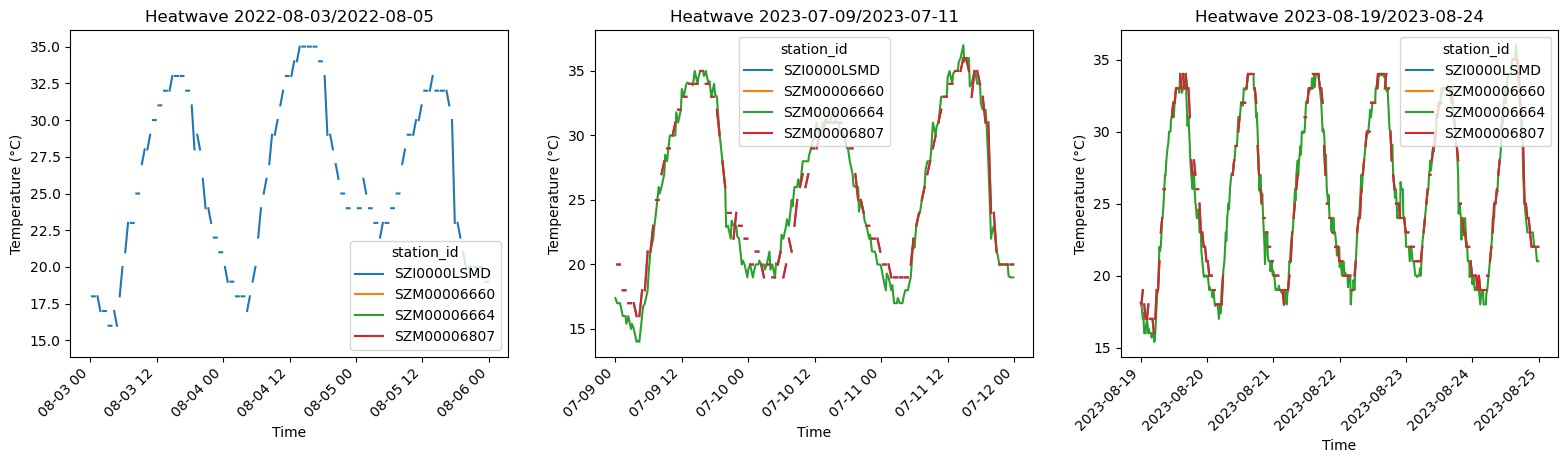

In [ ]:
heatwave_gb = heatwave_ts_df.groupby("heatwave")
fig, axes = plt.subplots(
    nrows=1, ncols=len(heatwave_gb), figsize=(len(heatwave_gb) * figwidth, figheight)
)
for (heatwave, _ts_df), ax in zip(heatwave_gb, axes):
    _ts_df.droplevel("heatwave").plot(ax=ax)
    ax.set_title(f"Heatwave {heatwave}")
    ax.set_ylabel("Temperature (°C)")
    ax.set_xlabel("Time")
    # rotate x-axis labels
    ax.tick_params(axis="x", rotation=45)

We can also use the `meteora.utils.get_heatwave_ts_df` to get the time series data frame for the heatwave periods directly, without having to first get the periods. To that end, instead of providing the `heatwave_periods` argument, we can use the same keyword arguments as in the `meteora.utils.get_heatwave_periods` function:

In [ ]:
heatwave_ts_df = utils.get_heatwave_ts_df(
    ts_df,
    heatwave_t_threshold=25,
    heatwave_n_consecutive_days=3,
    station_agg_func="mean",
    inter_station_agg_func="max",
)
heatwave_ts_df.head()

station_id                                 SZI0000LSMD  SZM00006660  \
heatwave              time                                            
2022-08-03/2022-08-05 2022-08-03 00:00:00          NaN         20.3   
                      2022-08-03 00:20:00         18.0          NaN   
                      2022-08-03 00:50:00         18.0          NaN   
                      2022-08-03 01:00:00          NaN         19.4   
                      2022-08-03 01:20:00         18.0          NaN   

station_id                                 SZM00006664  SZM00006807  
heatwave              time                                           
2022-08-03/2022-08-05 2022-08-03 00:00:00         17.8          NaN  
                      2022-08-03 00:20:00          NaN          NaN  
                      2022-08-03 00:50:00          NaN          NaN  
                      2022-08-03 01:00:00         16.0          NaN  
                      2022-08-03 01:20:00          NaN          NaN

## References

1. Al Khourdajie, A., van Diemen, R., Lamb, W. F., Pathak, M., Reisinger, A., Skea, J., ... & Steg, L. (2022). IPCC, 2022: Annex II: Definitions, Units and Conventions.
2. A. Burgstall, L. Fontannaz, M. Gaia, R. Gehrig, U. Graf, S. Gubler, S. Kotlarski, D. Murer, T. Schlegel, C. Schwierz, and C. Spirig, “Von den warnungen bis zur klimatologie – das thema hitze an der MeteoSchweiz,” Technical report MeteoSwiss No. 276 276, MeteoSwiss, 2021.